2.2.0-rc3
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteE2C6Z6/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteE2C6Z6/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteE2C6Z6/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>
<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>
['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']
8185
[[  62   27   57 ...    0    0    0]
 [3635   40 6183 ...    0    0    0]
 [ 407   13   12 ...    0    0    0]
 ...
 [ 398   63 1368 ...    0    0

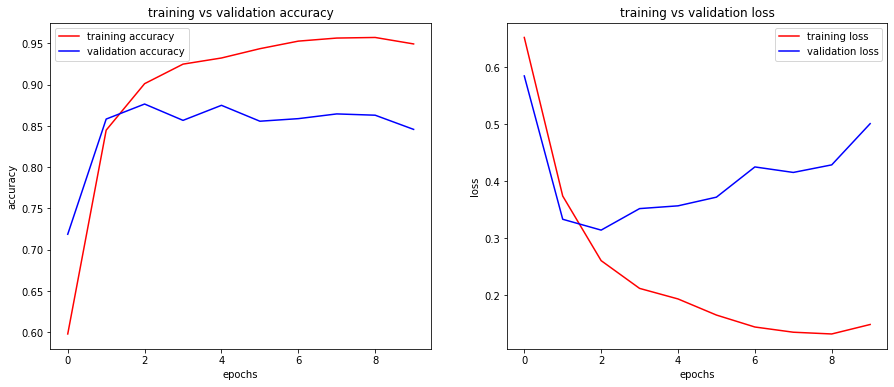

391/391 [==============================] - 16s 41ms/step - loss: 0.4485 - accuracy: 0.8572
Test Loss: 0.4484677016735077
Test Accuracy: 0.8571599721908569
[[0.4010913]]
[[0.3706075]]
(8185, 64)

-> Elapsed execution time: 592.2495 seconds.



In [1]:
# TensorFlow Tutorials
# Word Embeddings
# https://www.tensorflow.org/tutorials/text/word_embeddings
# Text Classification with RNN
# https://www.tensorflow.org/tutorials/text/text_classification_rnn
#
# https://www.tensorflow.org/tutorials/load_data/text
# https://www.tensorflow.org/tutorials/tensorflow_text/intro#tfdata_example
# https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TextEncoder
# https://developers.google.com/machine-learning/guides/text-classification/step-2-5?authuser=1
# masking: https://www.tensorflow.org/guide/keras/masking_and_padding
# keras rnn: https://www.tensorflow.org/guide/keras/rnn
# embedding projector: http://projector.tensorflow.org/


import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import *


starttime = datetime.now()


import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Load imdb review ds available in tf:
imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)


# Splitting into Train and Test data:
train_data, test_data = imdb['train'], imdb['test']

print(train_data)  # data is stored in a tensor of two columns: col 1 are the texts and col 2 the labels!
print(test_data)

# Creating the tokenizer from the text (we don't use the tokenizer available from the tdfs).
# how to tokenize the dataset using tf subwordtextencoder
# https://www.tensorflow.org/tutorials/load_data/text
#
# # build vocabulary from the text:
# tokenizer = tfds.features.text.Tokenizer()
#
# vocabulary_set = set()
# for text_tensor, _ in train_data:
#   some_tokens = tokenizer.tokenize(text_tensor.numpy())
#   vocabulary_set.update(some_tokens)
#
# vocab_size = len(vocabulary_set)
# print(vocab_size)

# Vocabulary used for the dataset:
encoder = info.features['text'].encoder
print(encoder.subwords[:20])
print(encoder.vocab_size)

# Padding the dataset:
buffer_size = 10000
batch_size = 64
# Note that the dataset is already tokenized to integer vectors:
train_batches = train_data.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([None],[]))
test_batches = test_data.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([None],[]))

train_batch, train_labels = next(iter(train_batches))
print(train_batch.numpy())
print(len(train_batch.numpy()))
print(train_batch.numpy().shape)


# Building the model:
embedding_dim = 64

model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim= encoder.vocab_size, output_dim= embedding_dim),  # input_length= train_batch.numpy().shape[1]),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001), # RMSprop(lr=0.001),  Adam with lr=1e-4 performs better than Adam lr=1e-4!
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # 'binary_crossentropy',  # from_logits is for when y is in tensor of probability. It doesn't seem necessary.
    metrics=['accuracy']
    )


# Train the model:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    targ = 0.99
    if (logs['accuracy']>targ) :
    # if logs.get('accuracy').astype(float)>targ :
    # if np.less(targ, logs.get('accuracy')) :
      print('Reached %0.1f%% training accuracy. Training converged and stopping!' %(targ*100))
      self.model.stop_training = True

callback = myCallback()

history= model.fit(train_batches,
                   epochs= 10,
                   validation_data= test_batches, 
                   validation_steps = 30,
                   # callbacks=[callback],
                   verbose=1)  


# Plot the training results:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(acc, 'r', label='training accuracy')
plt.plot(val_acc, 'b', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('training vs validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'r', label='training loss')
plt.plot(val_loss, 'b', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('training vs validation loss')
plt.legend()

plt.show()


# Evaluating the test dataset:
test_loss, test_acc = model.evaluate(test_batches)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# Making prediction:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)



# Retrieving the embeddings
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)


# Writing out the weights (embeddings):
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()



et1 = datetime.now() - starttime

print( '\n-> Elapsed execution time: %0.4f seconds.\n' %(et1.total_seconds()) )
